## Intro
In this notebook, transfer learning is used to train a model for classification. I will be using "Inception" model and I will train my model on top of it.

In [2]:
import numpy as np 
import pandas as pd 
import os
import random
import shutil
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
print(f"TF version is: {tf.__version__}")
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm

TF version is: 2.6.4


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
local_zip = '/kaggle/input/dogs-vs-cats/train.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


## Train and validation data
Split the data to train and validation and move them to correct folders:

In [5]:
train_path = '/train'
f_names = os.listdir(train_path)
print(f"count of data points: {len(f_names)}")

random.seed(1)
split_ratio = 0.8
sample_data = random.sample(f_names, len(f_names))
train_sample  = sample_data[:int(split_ratio * len(f_names))]
validation_sample = sample_data[int(split_ratio * len(f_names)):]

# Directory with training cat/dog pictures
train_cats_dir = '/train/cat'
train_dogs_dir = '/train/dog'

# Directory with validation cat/dog pictures
validation_cats_dir = '/validation/cat'
validation_dogs_dir = '/validation/dog'

# create directories:
os.makedirs(train_dogs_dir,exist_ok = True)
os.makedirs(train_cats_dir,exist_ok = True)
os.makedirs(validation_dogs_dir,exist_ok = True)
os.makedirs(validation_cats_dir,exist_ok = True)

# copy the data:
# train data:
for v in train_sample:
    if 'cat' in v.lower():
        shutil.copy('/train/'+ v,'/train/cat/'+ v)
    else:
         shutil.copy('/train/' + v,'/train/dog/' + v)

# validation data:
for v in validation_sample:
    if 'cat' in v.lower():
        shutil.copy('/train/'+ v,'/validation/cat/'+ v)
    else:
        shutil.copy('/train/'+ v,'/validation/dog/'+ v)

print(f'count of cats in training: {len(os.listdir(train_cats_dir))}')
print(f'count of dogs in training: {len(os.listdir(train_dogs_dir))}')

count of data points: 25000
count of cats in training: 10013
count of dogs in training: 9987


### Data pre-processing:

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory('/train',
                                                    batch_size=50,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory('/validation',
                                                         batch_size=50,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-12-03 22:53:08--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 142.251.107.128, 74.125.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  27.2MB/s    in 3.5s    

2022-12-03 22:53:12 (24.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

2022-12-03 22:53:44.908640: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [10]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
# model.summary()

In [12]:
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

2022-12-03 22:58:00.954857: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
100/100 - 165s - loss: 0.2078 - accuracy: 0.9274 - val_loss: 0.1192 - val_accuracy: 0.9524
Epoch 2/20
100/100 - 157s - loss: 0.0981 - accuracy: 0.9644 - val_loss: 0.1011 - val_accuracy: 0.9608
Epoch 3/20
100/100 - 157s - loss: 0.0878 - accuracy: 0.9692 - val_loss: 0.0912 - val_accuracy: 0.9636
Epoch 4/20
100/100 - 157s - loss: 0.0721 - accuracy: 0.9738 - val_loss: 0.0827 - val_accuracy: 0.9696
Epoch 5/20
100/100 - 158s - loss: 0.0610 - accuracy: 0.9782 - val_loss: 0.1063 - val_accuracy: 0.9648
Epoch 6/20
100/100 - 158s - loss: 0.0651 - accuracy: 0.9802 - val_loss: 0.0995 - val_accuracy: 0.9672
Epoch 7/20
100/100 - 158s - loss: 0.0454 - accuracy: 0.9866 - val_loss: 0.1016 - val_accuracy: 0.9660
Epoch 8/20
100/100 - 157s - loss: 0.0366 - accuracy: 0.9878 - val_loss: 0.1087 - val_accuracy: 0.9704
Epoch 9/20
100/100 - 156s - loss: 0.0382 - accuracy: 0.9880 - val_loss: 0.0889 - val_accuracy: 0.9724
Epoch 10/20
100/100 - 157s - loss: 0.0343 - accuracy: 0.9886 - val_loss: 0.1179 - 

In [18]:
import matplotlib.pyplot as plt
# function for plotting the accuracy and loss vs epochs
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = [0.]+history.history['accuracy']
    val_acc = [0.]+history.history['val_accuracy']
    loss = [0.]+history.history['loss']
    val_loss = [0.]+history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

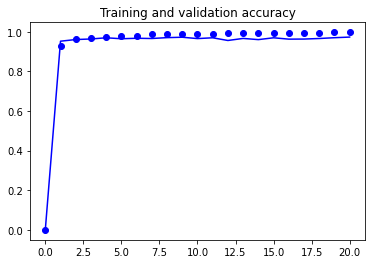

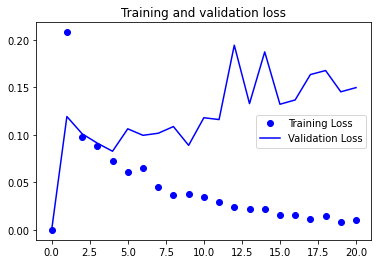

In [19]:
plot_loss_acc(history)